# Goal

Can a classification model determine if a wine is white or red?

Which classification model, if any, works best to classify this data based on these variables?

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading the csv, which already has an index column
df = pd.read_csv("wine-data/winemag-data-130k-v2.csv", index_col=0)

In [3]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Data in the description and designation columns are going to give away what kind of wine it is in many cases. We also are not interested in details about the taster of the wine. Additionally, the region information has a lot of variety but does not give us that much more data than country, province and winery. Thus, we'll remove those columns, as well as the title for each wine, and leave only columns that we hope will work as potential predicters of variety.

In [4]:
data = df.drop(columns=["description", "designation", "region_1", "region_2",
                        "taster_name", "taster_twitter_handle", "title"])

### Exploring the Data

In [5]:
data.head()

,country,points,price,province,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,White Blend,Nicosia
1,Portugal,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Riesling,St. Julian
4,US,87,65.0,Oregon,Pinot Noir,Sweet Cheeks


In [6]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [7]:
data.shape

(129971, 6)

In [8]:
# Checking for nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 6 columns):
country     129908 non-null object
points      129971 non-null int64
price       120975 non-null float64
province    129908 non-null object
variety     129970 non-null object
winery      129971 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 6.9+ MB


In [9]:
len(set(data["variety"]))

708

In [10]:
# Since the top 30 varieties account for more than 80% of our data,
# let's only use observations where the variety is one of those,
# to make it easier to create our target variable, red/white
top_30_variety_counts = data["variety"].value_counts()[:30]
top_30_variety_counts.sum()

105154

In [11]:
top_30_varieties = list(top_30_variety_counts.index)
print(top_30_varieties)

['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc', 'Syrah', 'Rosé', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec', 'Portuguese Red', 'White Blend', 'Sparkling Blend', 'Tempranillo', 'Rhône-style Red Blend', 'Pinot Gris', 'Champagne Blend', 'Cabernet Franc', 'Grüner Veltliner', 'Portuguese White', 'Bordeaux-style White Blend', 'Pinot Grigio', 'Gamay', 'Gewürztraminer', 'Viognier', 'Shiraz']


In [12]:
# Now, let's make our data just those where the variety is one of the top 30
data = data[data["variety"].isin(top_30_varieties)]

In [13]:
data.head()

,country,points,price,province,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,White Blend,Nicosia
1,Portugal,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Riesling,St. Julian
4,US,87,65.0,Oregon,Pinot Noir,Sweet Cheeks


In [14]:
# I made the color dictionary by hand for this, to make it easier to see
# which wines are in which category here
# For the curious, I'm considering a Rose a white for simplicity
color = {"red": ["Pinot Noir", "Cabernet Sauvignon", "Red Blend",
                 "Bordeaux-style Red Blend", "Syrah", "Merlot", "Nebbiolo",
                 "Zinfandel", "Sangiovese", "Malbec", "Portuguese Red",
                 "Tempranillo", "Rhône-style Red Blend", "Cabernet Franc",
                 "Gamay", "Shiraz"],
         "white": ["Chardonnay", "Riesling", "Sauvignon Blanc", "Rosé",
                   "White Blend", "Sparkling Blend", "Pinot Gris",
                   "Champagne Blend", "Grüner Veltliner", "Portuguese White",
                   "Bordeaux-style White Blend", "Pinot Grigio",
                   "Gewürztraminer", "Viognier"]}

In [15]:
print(color["red"])
print(color["white"])

['Pinot Noir', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Syrah', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec', 'Portuguese Red', 'Tempranillo', 'Rhône-style Red Blend', 'Cabernet Franc', 'Gamay', 'Shiraz']
['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'Rosé', 'White Blend', 'Sparkling Blend', 'Pinot Gris', 'Champagne Blend', 'Grüner Veltliner', 'Portuguese White', 'Bordeaux-style White Blend', 'Pinot Grigio', 'Gewürztraminer', 'Viognier']


In [16]:
# Creating our new target column, color
def find_color(variety):
    if variety in color["red"]:
        var_color = "red"
    elif variety in color["white"]:
        var_color = "white"
    else:
        var_color = "whoops"
    return var_color
data["color"] = df["variety"].map(lambda x: find_color(x))

In [17]:
# Dropping our variety column, since we no longer need it
data = data.drop(columns="variety")

In [18]:
data.head()

,country,points,price,province,winery,color
0,Italy,87,NaN,Sicily & Sardinia,Nicosia,white
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,red
2,US,87,14.0,Oregon,Rainstorm,white
3,US,87,13.0,Michigan,St. Julian,white
4,US,87,65.0,Oregon,Sweet Cheeks,red


In [19]:
# Our classes are unbalanced, something we should keep in mind later
data["color"].value_counts()

red      65687
white    39467
Name: color, dtype: int64

In [20]:
# Let's go ahead and remove our target variable
target = data["color"]
data = data.drop(columns="color")

In [21]:
# Now let's look at our NaNs and datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105154 entries, 0 to 129970
Data columns (total 5 columns):
country     105114 non-null object
points      105154 non-null int64
price       98166 non-null float64
province    105114 non-null object
winery      105154 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 4.8+ MB


In [22]:
# First things first, let's deal with our nulls
# Only 40 entries, out of over 100,000, are missing country/province data
# So I will drop those, rather than guessing or looking up the winery by hand

data["country"].isna().sum()

40

In [23]:
data.dropna(subset=["country","province"], inplace=True)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105114 entries, 0 to 129970
Data columns (total 5 columns):
country     105114 non-null object
points      105114 non-null int64
price       98130 non-null float64
province    105114 non-null object
winery      105114 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 4.8+ MB


In [25]:
# We still have a lot of nulls in our price column.
# Rather than removing all of those values, I'll create a new column to track
# which observations were missing price data, then fill the nulls

data['price_missing'] = np.where(np.isnan(data['price']) == True, 1, 0)

In [26]:
# Checking what seems more reasonable, median or mean - median wins
# Mean is more affected by the outliers in our data, which there are several
print(data["price"].median())
print(data["price"].mean())

27.0
36.71797615408132


In [27]:
# Replacing nulls with median price
clean_data = data.copy()
clean_data["price"].fillna(clean_data["price"].median(), inplace=True)

In [28]:
clean_data.head()

,country,points,price,province,winery,price_missing
0,Italy,87,27.0,Sicily & Sardinia,Nicosia,1
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,0
2,US,87,14.0,Oregon,Rainstorm,0
3,US,87,13.0,Michigan,St. Julian,0
4,US,87,65.0,Oregon,Sweet Cheeks,0


In [29]:
# Now, let's deal with our categorical variables
# There are too many unique entries in each of our categorical columns, so 
# instead we'll simply label encode each using sklearn

from sklearn.preprocessing import LabelEncoder
labeler = LabelEncoder()

clean_data["country"] = labeler.fit_transform(clean_data["country"].astype(str))
clean_data["province"] = labeler.fit_transform(clean_data["province"].astype(str))
clean_data["winery"] = labeler.fit_transform(clean_data["winery"].astype(str))

In [34]:
clean_data.head()

,country,points,price,province,winery,price_missing
0,19,87,27.0,285,10344,1
1,28,87,15.0,92,11510,0
2,37,87,14.0,228,11565,0
3,37,87,13.0,185,12777,0
4,37,87,65.0,228,12990,0


In [38]:
# Creating a correlation dataframe to investigate
map_corr = np.corrcoef(clean_data, rowvar=False)

In [39]:
# Prepping the correlation dataframe to be visualized
map_corr = pd.DataFrame(map_corr,
                        columns=["country", "points", "price",
                                 "province", "winery", "price_missing"],
                        index=["country", "points", "price", "province", 
                               "winery", "price_missing"])

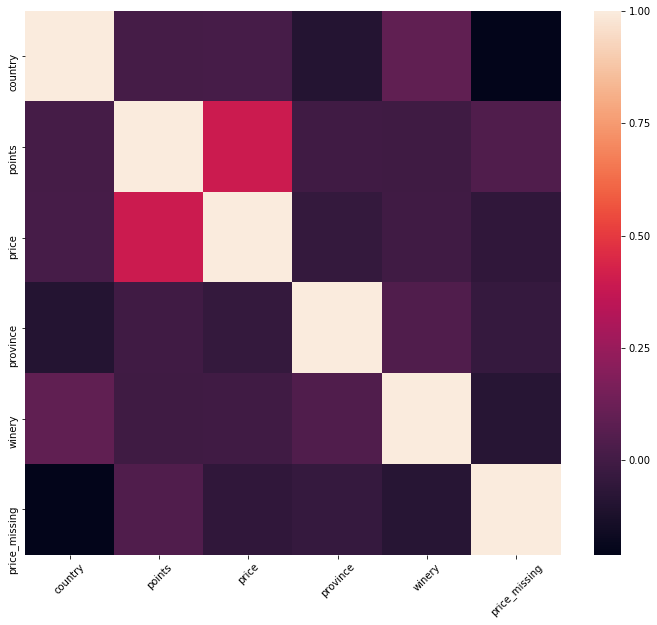

In [40]:
# Plotting the correlation of my variables
plt.figure(figsize=(12,10))
ax = sns.heatmap(data = map_corr)
plt.xticks(rotation=45) 
plt.show()

In [31]:
# Let's check if replacing price nulls with the median affected correlation
zero_data = data.copy()
zero_data["price"].fillna(value=0, inplace=True)

In [33]:
# Label encoding for this dataframe
zero_data["country"] = labeler.fit_transform(zero_data["country"].astype(str))
zero_data["province"] = labeler.fit_transform(zero_data["province"].astype(str))
zero_data["winery"] = labeler.fit_transform(zero_data["winery"].astype(str))

In [42]:
# Creating the correlation dataframe for the zero df
zero_corr = np.corrcoef(zero_data, rowvar=False)
zero_corr = pd.DataFrame(zero_corr,
                        columns=["country", "points", "price",
                                 "province", "winery", "price_missing"],
                        index=["country", "points", "price", "province", 
                               "winery", "price_missing"])

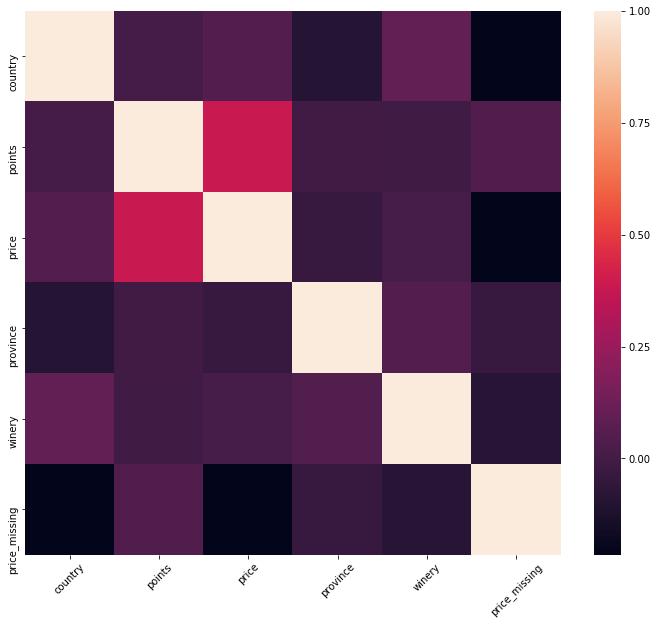

In [44]:
# Now, plotting to check if the correlation is noticably different for price
# It's not! Not much different at all from the previous heatmap, so
# changing our nulls to the median was probably fine
plt.figure(figsize=(12,10))
ax = sns.heatmap(data = zero_corr)
plt.xticks(rotation=45) 
plt.show()

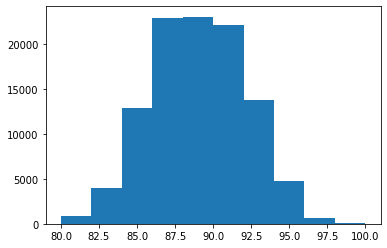

In [35]:
# Checking out the distribution of our 'points' variable - fairly normal
plt.hist(clean_data["points"])
plt.show()

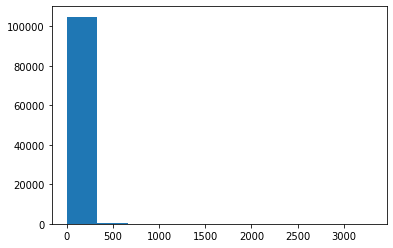

In [37]:
# Checking out the distribution of our 'price' variable - not normal at all!

plt.hist(clean_data["price"])
plt.show()